In [ ]:
"""
BoW나 BoW에 기반한 단어 표현 방법인 DTM, TF-IDF, 또는 뒤에서 배우게 될 워드투벡터(Word2Vec) 등과 같이 
단어를 수치화할 수 있는 방법을 이해했다면, 이러한 표현 방법에 대해서 코사인 유사도를 이용하여 문서의 
유사도를 구하는 게 가능하다.
"""

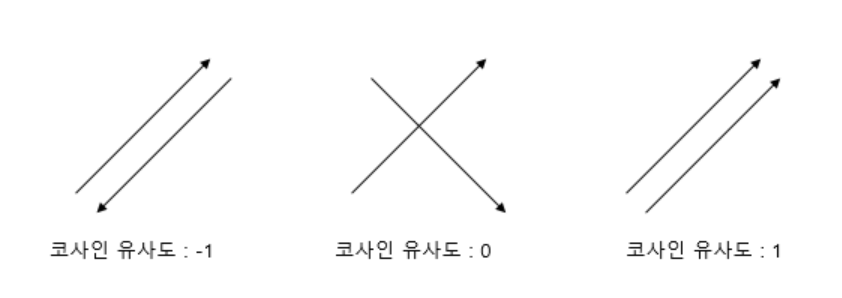

In [1]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

In [2]:
doc1=np.array([0,1,1,1])
doc2=np.array([1,0,1,1])
doc3=np.array([2,0,2,2])

In [3]:
print(cos_sim(doc1, doc2)) #문서1과 문서2의 코사인 유사도
print(cos_sim(doc1, doc3)) #문서1과 문서3의 코사인 유사도
print(cos_sim(doc2, doc3)) #문서2과 문서3의 코사인 유사도

0.6666666666666667
0.6666666666666667
1.0000000000000002


In [4]:
"""
유사도를 이용한 추천 시스템 구현
"""
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [16]:
data = pd.read_csv('C:/Users/user/Desktop/movies_metadata.csv')
data.head(2)

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [17]:
data = data.head(20000)

In [18]:
data['overview'].isnull().sum() # tf-idf를 할때 데이터에 Null값이 있으면 에러가 발생한다. 따라서 확인해준다.

135

In [19]:
# overview에서 Null 값을 가진 경우에는 Null 값을 제거
data['overview'] = data['overview'].fillna('')

In [20]:
tfidf = TfidfVectorizer(stop_words='english')
# overview에 대해서 tf-idf 수행
tfidf_matrix = tfidf.fit_transform(data['overview'])
print(tfidf_matrix.shape)

(20000, 47487)


In [21]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [22]:
indices = pd.Series(data.index, index=data['title']).drop_duplicates()
print(indices.head())

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


In [23]:
idx = indices['Father of the Bride Part II']
print(idx)

4


In [24]:
# 이제 선택한 영화에 대해서 코사인 유사도를 이용하여, 가장 overview가 유사한 10개의 영화를 찾아내는 함수를 만든다.

def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀로부터 해당되는 인덱스를 받아옵니다. 이제 선택한 영화를 가지고 연산할 수 있습니다.
    idx = indices[title]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구합니다.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 영화들을 정렬합니다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 10개의 영화를 받아옵니다.
    sim_scores = sim_scores[1:11]

    # 가장 유사한 10개의 영화의 인덱스를 받아옵니다.
    movie_indices = [i[0] for i in sim_scores]

    # 가장 유사한 10개의 영화의 제목을 리턴합니다.
    return data['title'].iloc[movie_indices]

In [25]:
# 영화 다크나이트 라이즈와 overview가 유사한 영화들을 찾아본다.
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

In [ ]:
"""
문서의 유사도를 구하기 위해선 코사인 유사도 외에 여러가지 방법이 있다.
    1) 유클리드 거리: 앞서본 2차원을 단어의 총 개수만큼의 차원으로 확장하는 것과 같다.
    2) 자카드 유사도: 합집합에서 교집합의 비율을 구한다면 두 집합 A와 B의 유사도를 구할수 있다는 개념
"""

In [26]:
# 유클리드 거리
import numpy as np
def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

doc1 = np.array((2,3,0,1))
doc2 = np.array((1,2,3,1))
doc3 = np.array((2,1,2,2))
docQ = np.array((1,1,0,1))

print(dist(doc1,docQ))
print(dist(doc2,docQ))
print(dist(doc3,docQ))

2.23606797749979
3.1622776601683795
2.449489742783178


In [27]:
# 자카드 유사도
# 다음과 같은 두 개의 문서가 있다.
# 두 문서 모두에서 등장한 단어는 apple과 banana 2개.
doc1 = "apple banana everyone like likey watch card holder"
doc2 = "apple banana coupon passport love you"

# 토큰화를 수행합니다.
tokenized_doc1 = doc1.split()
tokenized_doc2 = doc2.split()

# 토큰화 결과 출력
print(tokenized_doc1)
print(tokenized_doc2)

['apple', 'banana', 'everyone', 'like', 'likey', 'watch', 'card', 'holder']
['apple', 'banana', 'coupon', 'passport', 'love', 'you']


In [28]:
# 문서1과 문서2의 합집합
union = set(tokenized_doc1).union(set(tokenized_doc2))
print(union)

{'like', 'holder', 'card', 'passport', 'coupon', 'apple', 'likey', 'everyone', 'you', 'love', 'watch', 'banana'}


In [29]:
# 문서1과 문서2의 교집합
intersection = set(tokenized_doc1).intersection(set(tokenized_doc2))
print(intersection)

{'apple', 'banana'}


In [30]:
print(len(intersection)/len(union)) # 2를 12로 나눔.

0.16666666666666666
